In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

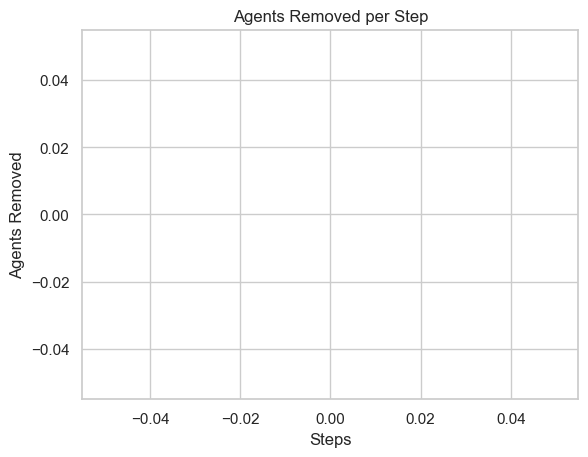

In [25]:
# Load the data from the CSV file
data = pd.read_csv("agents_removed_per_step.csv")

# prepare the data for plotting
steps = np.linspace(0, len(data), len(data))

# visualize the data
plt.plot(steps, data["Agents Removed"])
plt.xlabel("Steps")
plt.ylabel("Agents Removed")
plt.title("Agents Removed per Step")
plt.show()

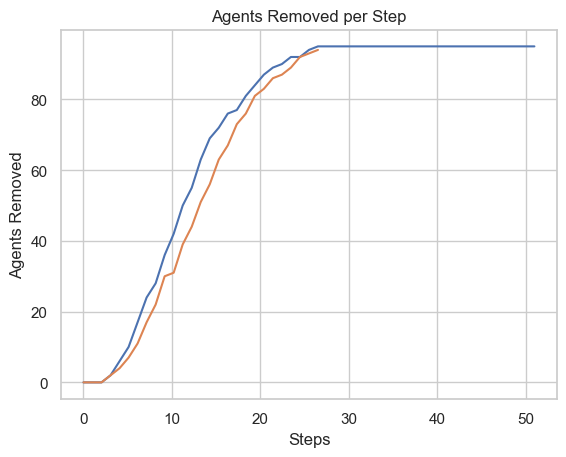

In [26]:
# Load the data from the CSV file
data = pd.read_csv("agents_removed_per_step_all_runs.csv")

for i in range(len(data.columns)):
    # prepare the data for plotting taking column i
    steps = np.linspace(0, len(data.iloc[:, i]), len(data.iloc[:, i]))

    # visualize the data
    plt.plot(steps, data.iloc[:, i])

plt.xlabel("Steps")
plt.ylabel("Agents Removed")
plt.title("Agents Removed per Step")
    
plt.show()

In [27]:

def plot_param_var_conf(ax, df, var, param):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variable to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err, alpha=0.2)

    ax.set_xlabel(var)
    ax.set_ylabel(param)
    ax.set_title(f"{param} vs {var}")

def plot_all_vars(df):
    """
    Plots the parameters vs each of the output variables.

    Args:
        df: dataframe that holds all data
    """

    output_vars = [col for col in df.columns if col not in ['parameter', 'value']]

    num_vars = len(output_vars)
    fig, axs = plt.subplots(num_vars, figsize=(7, 10))

    for i, param in enumerate(output_vars):
        plot_param_var_conf(axs[i], df, 'parameter', param)

    fig.tight_layout()
    plt.show()

AttributeError: 'Axes' object has no attribute 'hline'

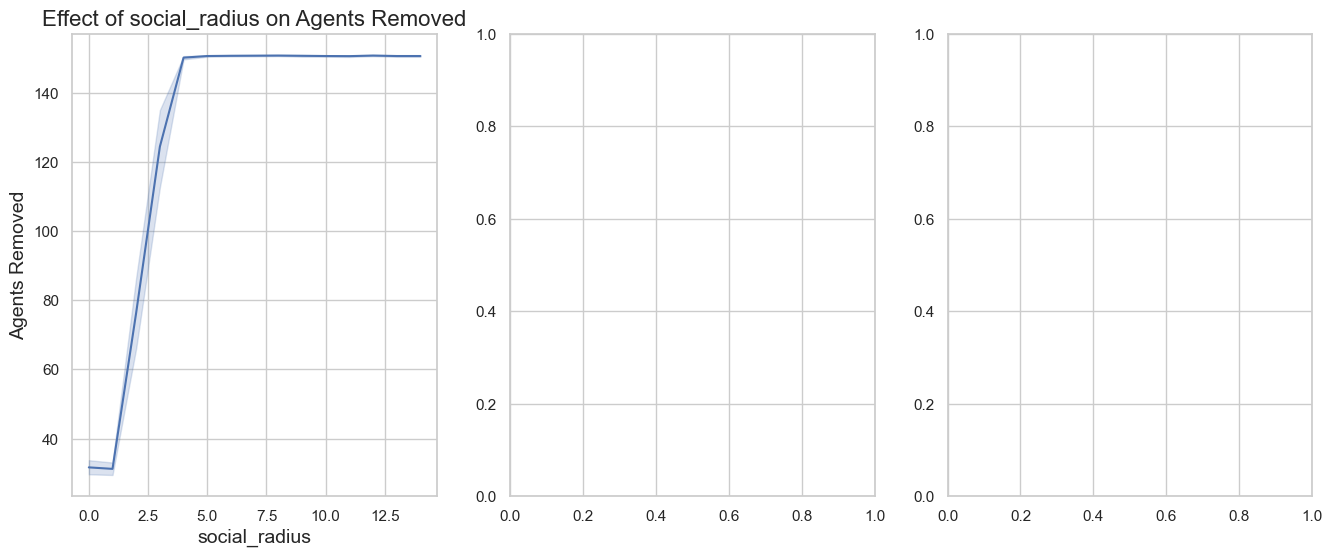

In [30]:
df = pd.read_csv('sensitivity_analysis_results.csv')

# Filter out the relevant columns
relevant_cols = ['parameter', 'value', 'Agents Removed']
df = df[relevant_cols]

# Group by parameter and calculate statistics
parameter_stats = df.groupby('parameter').agg({
    'value': 'first', 
    'Agents Removed': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()

def plot_parameter_effects(num_of_plots, name_of_vars):
    """
    Plots the effects of two parameters on the 'Agents Removed' metric side by side.
    """
    
    fig, axes = plt.subplots(1, num_of_plots, figsize=(16, 6))  # Create a grid of 1 row and 2 columns
    
    for i in range(len(name_of_vars)):
        # Plot for the first parameter
        sns.lineplot(ax=axes[i], x='value', y='Agents Removed', data=df[df['parameter'] == name_of_vars[i]])
        axes[i].set_title(f'Effect of {name_of_vars[i]} on Agents Removed', fontsize=16)
        axes[i].set_xlabel(f'{name_of_vars[i]}', fontsize=14)
        axes[i].set_ylabel('Agents Removed', fontsize=14)
        axes[i].hline()
        axes[i].grid(True)

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

# Plot effects of 'social_radius' and 'fire_radius' and "exit_radius" side by side
plot_parameter_effects(3, ['social_radius', 'fire_radius', 'exit_radius'])

# Plot effects of 'p_spreading' and 'p_spreading_environment' side by side
plot_parameter_effects(2, ['p_spreading', 'p_spreading_environment'])
